# Models that I used 
1. Linear Regresion (LB = **0.7799**)
2. Naive Bayes (LB = **0.7703**)
3. Decision Tree (LB = **0.811**)
4. Linear SVM (LB = **0.7966**)

And in the end we do assembly of models, and we got:
* LR + NB + DT + SVM (LB = **0.7994**)
* SVM + DT (LB = **0.8205**)
* NB + DT (LB = **0.8253** )

For choosing parameters I used function cross_val_score(cv=10,scoring='roc_auc')
with: 10 folds and with scoring function: ROC accuracy. Also, all models get better on CV score than on the LB. Only in the Decision Tree models, I used parameters according to LB. 

# Importing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Here we load prepared data from notebook [Titanic data preparation](https://www.kaggle.com/mkulio/titanic-data-preparation).
Prepared data has new features:
* "Title" - title of the passenger, derived from "Name" column, which can be Master, Miss, Mrs, Mr, and Revenant
* "FamilyName" - derived from original "Name" column
* "TicketNumber" - derived from original "Ticket" column
* "Mix" - combination of "TicketNumber", "Pclass" and "Embarked" features
* "TicketGroup" - number of passengers that have the same "Mix" feature 
* "FamilySize" - this is "Parch" + "SibSp" + 1

A detailed description of the above features and code behind them you may found in the mentioned notebook.

In [2]:
cd /kaggle/input/titanic-data-preparation

/kaggle/input/titanic-data-preparation


In [3]:
train_data = pd.read_csv('train_prep.csv')
test_data = pd.read_csv('test_prep.csv')
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'TicketNumber', 'FamilyName', 'Title', 'Mix', 'TicketGroup',
       'FamilySize', 'PassengerId'],
      dtype='object')

In [4]:
train_data.set_index('PassengerId',inplace = True)
test_data.set_index('PassengerId',inplace = True)

In [5]:
all_data = pd.concat([train_data,test_data])

In [6]:
print(train_data.shape,test_data.shape)
print(all_data.shape)

(891, 15) (418, 15)
(1309, 15)


# Adding new features

Creating Bins for Age column and Fare column

In [7]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [8]:
all_data['FareBin'] = pd.qcut(all_data['Fare'], 5)
all_data['AgeBin'] = pd.cut(all_data['Age'],[0,2,5,12,18,80])

In [9]:
all_data['FareBin_Code'] = label.fit_transform(all_data['FareBin'])
all_data['AgeBin_Code'] = label.fit_transform(all_data['AgeBin'])

In [10]:
all_data.drop(columns=['AgeBin'],inplace=True)
all_data.drop(columns=['FareBin'],inplace=True)

Next, we create "Srate" column which represents passenger's survival rate. Idea is from the notebooks:
* [Titanic [0.82] - [0.83]](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83) by KonstantinMasich
* [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever) by ShunjiangXu

I modified code a lot, which may be seen in the next few lines:

In [11]:
for i in range(1,len(all_data)+1):
    all_data.loc[i,'Srate']=0.5

In [12]:
for i in range(1,len(all_data)+1):
    number = all_data.loc[i,'TicketNumber']
    group = all_data.loc[i,'TicketGroup'] 
    if group>1:
        max = all_data.drop(i)[all_data.drop(i)['TicketNumber']==number]['Survived'].max()
        if not pd.isna(max):
            all_data.loc[i,'Srate']=all_data.drop(i)[all_data.drop(i)['TicketNumber']==number]['Survived'].max()

In [13]:
all_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TicketNumber,FamilyName,Title,Mix,TicketGroup,FamilySize,FareBin_Code,AgeBin_Code,Srate
PassengerId,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,21171,Braund,Mr,S-3-21171,1.0,2,0,4,0.5
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,17599,Cumings,Mrs,C-1-17599,2.0,2,4,4,0.5
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,3101282,Heikkinen,Miss,S-3-3101282,1.0,1,1,4,0.5
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,113803,Futrelle,Mrs,S-1-113803,2.0,2,4,4,0.0
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,373450,Allen,Mr,S-3-373450,1.0,1,1,4,0.5


# Exploring features

In [14]:
train_data = all_data[:891]
test_data = all_data[891:]

In [15]:
numerical = ["Pclass","Age","SibSp","Parch","Fare","TicketGroup","FamilySize","FareBin_Code","AgeBin_Code","Srate","TicketNumber"]
categorical = ["Embarked","Title","Sex"]
all_features = numerical + categorical

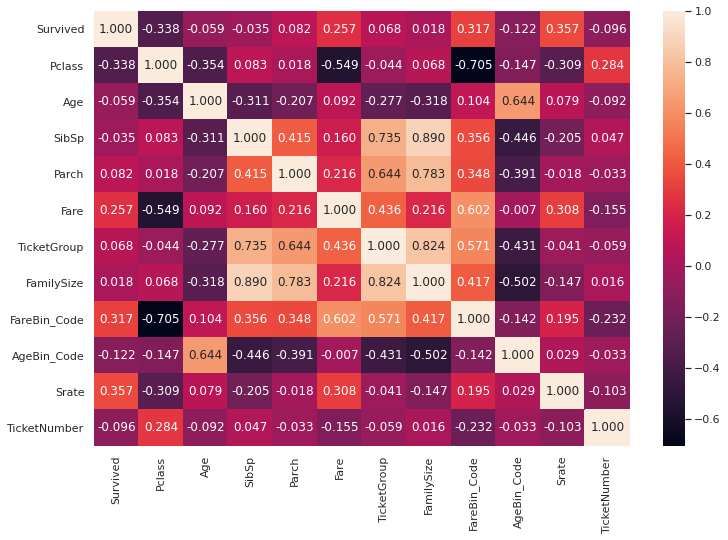

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(train_data[["Survived"]+numerical].corr(),annot=True, fmt = ".3f")

*From the above corr table we see the impact of creating bins for "Fare" and "Age" and "Srate" column*

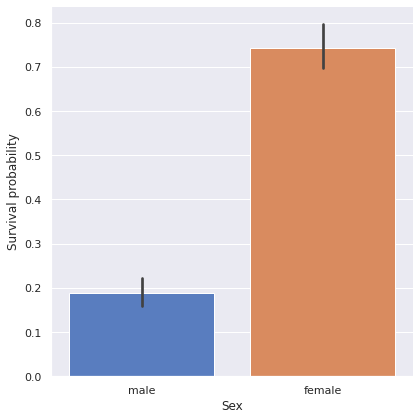

In [17]:
g = sns.catplot(x="Sex",y="Survived",data=train_data,kind="bar", height = 6 , palette = "muted")
g.set_ylabels("Survival probability")

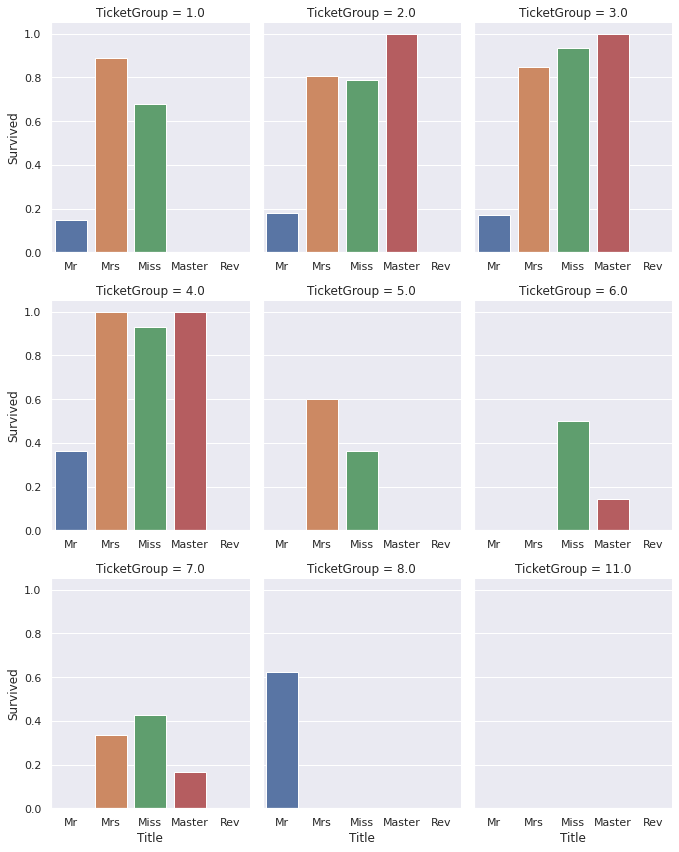

In [18]:
g = sns.catplot(x="Title", y="Survived",col="TicketGroup", data=train_data, kind="bar", col_wrap=3,height=4, aspect=.8,legend=True,sharex=False, ci=None)
for ax in g.axes.flatten():
    ax.set_xticklabels(["Mr","Mrs","Miss","Master","Rev"])

Looking at the above graphs, one may presume that "Title" has a significant impact on creating a model. That is not the case with my single best model - we did not use "Title column" in Decision Tree classification. But in the end, with assembly, we used the Naive Bayes model which uses the "Title" column.

# Modeling

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

In [20]:
y = train_data['Survived']
X = train_data.drop(columns = ['Survived'])

## 1. Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1.9)

In [22]:
num_att_LR = ["Pclass","Age","TicketNumber","SibSp","Parch","Srate","Fare"]
cat_att1_LR = ["Sex"]
cat_att2_LR = ["Title"]
drop_att_LR = list(set(all_features) - set(num_att_LR+cat_att1_LR+cat_att2_LR))

full_pipline_LR = ColumnTransformer([
    ("toDrop",'drop',drop_att_LR),
    ("numerical",StandardScaler(),num_att_LR),
    ("categorical1",OrdinalEncoder(),cat_att1_LR),
    ("categorical2",OneHotEncoder(),cat_att2_LR)
])

In [23]:
X_prep = full_pipline_LR.fit_transform(X)
cross_val_score(log_reg,X_prep,y,cv=10,scoring='roc_auc').mean()

0.8982831678125797

On the LB this model gets **0.7799**

## 2. Naive Bayes

In [24]:
from sklearn.naive_bayes import CategoricalNB
cat_bayes = CategoricalNB(alpha=0.05)

In [25]:
num_att_NB = ["FareBin_Code","AgeBin_Code"]
cat_att_NB = ["Title"]
drop_att_NB = list(set(all_features) - set(num_att_NB+cat_att_NB))

full_pipline_NB = ColumnTransformer([
    ("cat",OrdinalEncoder(),cat_att_NB),
    ("num",'passthrough',num_att_NB),
    ("drop",'drop',drop_att_NB)
])

In [26]:
X_prep = full_pipline_NB.fit_transform(X)
cross_val_score(cat_bayes,X_prep,y,cv=10,scoring='roc_auc').mean()

0.8301997566703448

On the LB NaiveBayes gets score of **0.7703**

## 3. Decision Tree
Here, I used grid search for finding the best hyperparameters for Decision Tree. If we use more features to decide splitting, we get better LB score.

In [27]:
from sklearn import tree

In [28]:
num_att_DT =["Pclass","FamilySize","Srate","AgeBin_Code","FareBin_Code"]
cat_att_DT = ["Sex"]
drop_att_DT = list(set(all_features) - set(num_att_DT + cat_att_DT))

full_pipline_DT = ColumnTransformer([
    ("droping",'drop',drop_att_DT),
    ("num",'passthrough',num_att_DT),
    ("cat",OrdinalEncoder(),cat_att_DT),
])

In [29]:
X_prep = full_pipline_DT.fit_transform(X)

In [30]:
criterion = ["gini", "entropy"]
max_depth = list(range(1,12,1))
max_features = [1,2,3,4,5,6]
splitter = ["best","random"]
min_samples_split = [2,3]
hyperparams = {'criterion': criterion, 'max_depth': max_depth, 'max_features': max_features, 
               'splitter': splitter, 'min_samples_split': min_samples_split}

gd = GridSearchCV(estimator = tree.DecisionTreeClassifier(random_state=1), param_grid = hyperparams, verbose=0, 
                cv=10, scoring = "roc_auc")

In [31]:
gd.fit(X_prep, y)
print(gd.best_score_)
print(gd.best_estimator_)

0.8950068471833179
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=3,
                       random_state=1, splitter='random')


Those parameters get us a score of **0.7847**. The interesting thing is when we use a model that is different from this one only in one thing - **max_features = 6**, we get score of **0.811**. So we use this model:

In [32]:
DT_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=6,
                       random_state=1, splitter='random') 

## 4. Suport Vector Machines
I tried LinearSVC and SVC with the polynomial kernel, but my grid search didn't, gave a significant result compared to Linear SVC, so I left Linear kernel.

In [33]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
svm_clf = LinearSVC(C=0.1, loss = 'hinge', max_iter=100000, random_state=1,)

In [34]:
num_att_SVM = numerical
cat_att1_SVM = ["Sex"]
cat_att2_SVM = ["Title"]
drop_att_SVM = list(set(all_features) - set(num_att_SVM + cat_att1_SVM+cat_att2_SVM))

full_pipline_SVM = ColumnTransformer([
    ("drop",'drop',drop_att_SVM),
    ("cat",OrdinalEncoder(),cat_att1_SVM),
    ("num",StandardScaler(),num_att_SVM),
    ("cat2",OneHotEncoder(),cat_att2_SVM),
])

In [35]:
X_prep = full_pipline_SVM.fit_transform(X)
cross_val_score(svm_clf,X_prep,y,cv=10,scoring='roc_auc').mean()

0.8830509011685482

With SVM model we get **0.7966** on the LB

## 5. Voting
Here, we create pipelines for four models that we use, and we tried all sorts of combinations. The conclusion is that we get the best LB result with a combination of the Decision Tree model and with the Naive Bayes classification model.

In [36]:
LR_pipe = Pipeline([('logReg pipline', full_pipline_LR), 
                  ('log_reg', log_reg)])

cross_val_score(LR_pipe,X,y,cv=10,scoring='accuracy').mean()

0.8417727840199751

In [37]:
NB_pipe = Pipeline([('NaiveBayes pipline', full_pipline_NB), 
                  ('cat_bayes', cat_bayes)])

cross_val_score(NB_pipe,X,y,cv=10,scoring='accuracy').mean()

0.7823720349563046

In [38]:
DT_pipe = Pipeline([('DecisionTree pipline', full_pipline_DT), 
                  ('Decision Tree', DT_clf)])

cross_val_score(DT_pipe,X,y,cv=10,scoring='accuracy').mean()

0.8327590511860172

In [39]:
SVM_pipe = Pipeline([('SVM pipline', full_pipline_SVM), 
                  ('SVM', svm_clf)])

cross_val_score(SVM_pipe,X,y,cv=10,scoring='accuracy').mean()

0.8338826466916354

First, we tried all four models, and this wasn't a good idea.

In [40]:
voting_clf_4 = VotingClassifier(
    estimators = [('Logistic Regresion',LR_pipe),('SVM',SVM_pipe),('Naive Bayes',NB_pipe),('Decision Tree',DT_pipe)],
    voting = 'hard'
)

cross_val_score(voting_clf_4,X,y,cv=10,scoring='accuracy').mean()

0.8406616729088638

This gets us to **0.7994** on the Ladder Board.

In [41]:
voting_clf_SVM_DT = VotingClassifier(
    estimators = [('SVM',SVM_pipe),('Decision Tree',DT_pipe)],
    voting = 'hard'
)

cross_val_score(voting_clf_SVM_DT,X,y,cv=10,scoring='accuracy').mean()

0.8350187265917602

This assembly of SVM and DT models gives us improvment to **0.8205**

In [42]:
voting_clf_NB_DT = VotingClassifier(
    estimators = [('Naive Bayes',NB_pipe),('Decision Tree',DT_pipe)],
    voting = 'hard'
)
cross_val_score(voting_clf_NB_DT,X,y,cv=10,scoring='accuracy').mean()

0.8316853932584269

Naive Bayes with Decision Tree gets us to **0.82535**

# Output

In [43]:
X_test = test_data.drop(columns=['Survived'])

In [44]:
voting_clf_NB_DT.fit(X,y)

VotingClassifier(estimators=[('Naive Bayes',
                              Pipeline(steps=[('NaiveBayes pipline',
                                               ColumnTransformer(transformers=[('cat',
                                                                                OrdinalEncoder(),
                                                                                ['Title']),
                                                                               ('num',
                                                                                'passthrough',
                                                                                ['FareBin_Code',
                                                                                 'AgeBin_Code']),
                                                                               ('drop',
                                                                                'drop',
                                                        

In [45]:
predictions = voting_clf_NB_DT.predict(X_test)
predictions = pd.to_numeric(predictions, downcast='integer')
output = pd.DataFrame({'PassengerId': list(X_test.index), 'Survived': predictions})

In [46]:
cd /kaggle/working

/kaggle/working


In [47]:
output.to_csv('Submission_NB_DT.csv', index=False)